d:\Software\anaconda\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Software\anaconda\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\enosj/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


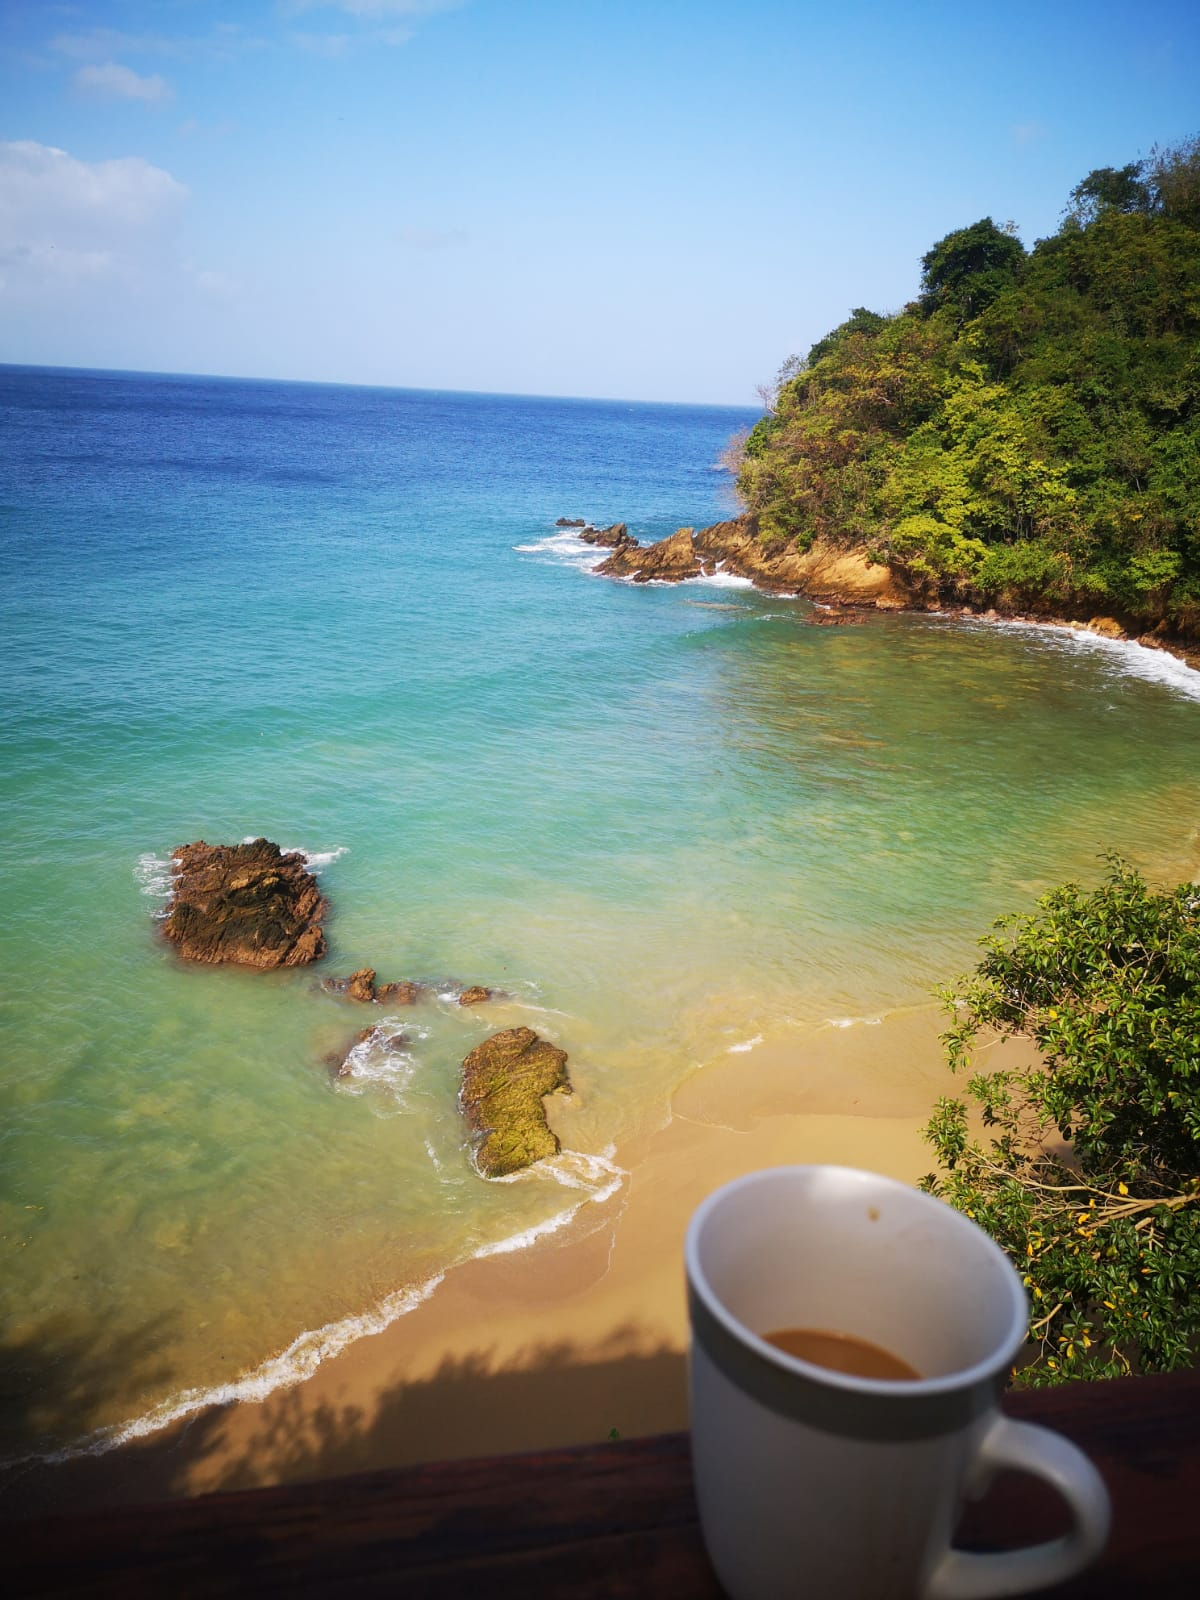

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt

import requests
from io import BytesIO

vgg = models.vgg16(pretrained = True)
vgg = vgg.cuda()
vgg.eval()

#input image
url = 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

from IPython.display import Image as Img
display(img)

In [2]:
from PIL import Image
# Register a hook on the target layer (used to get the output channels of the layer)
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()
  
# Make gradients calculations from the output channels of the target layer  
def get_gradients(net_in, net, layer):     
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  loss = hook.output[0].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

# Denormalization image transform
denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                              transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                              ])

# Run the Google Deep Dream.
def dream(image, net, layer, iterations, lr):
  image_tensor = transforms.ToTensor()(image)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  for i in range(iterations):
    gradients = get_gradients(image_tensor, net, layer)
    image_tensor.data = image_tensor.data + lr * gradients.data

  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy().transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

### First Try

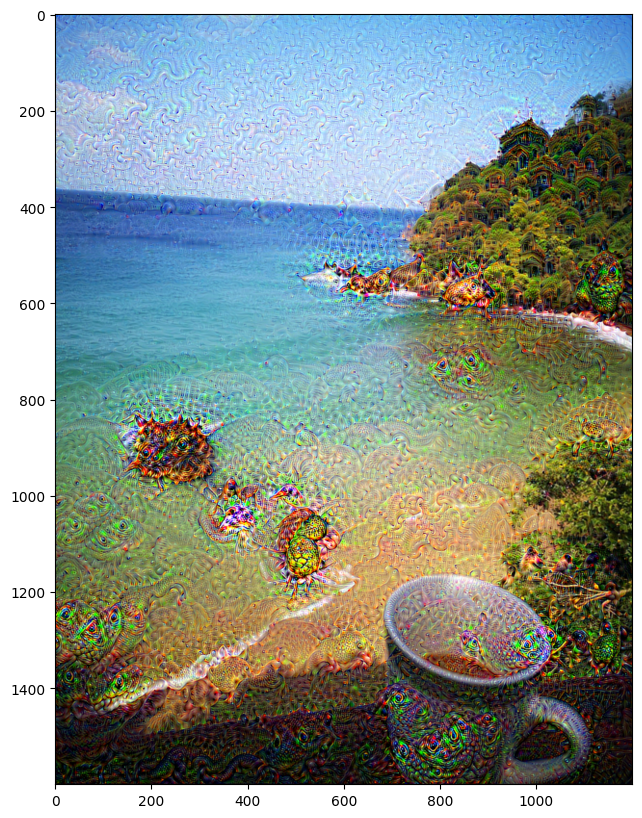

In [3]:
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
img = img.resize(new_size.astype(int))
layer = list( vgg.features.modules() )[27]

# Execute our Deep Dream Function 
img = dream(img, vgg, layer, 20, 1)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)

### Improve

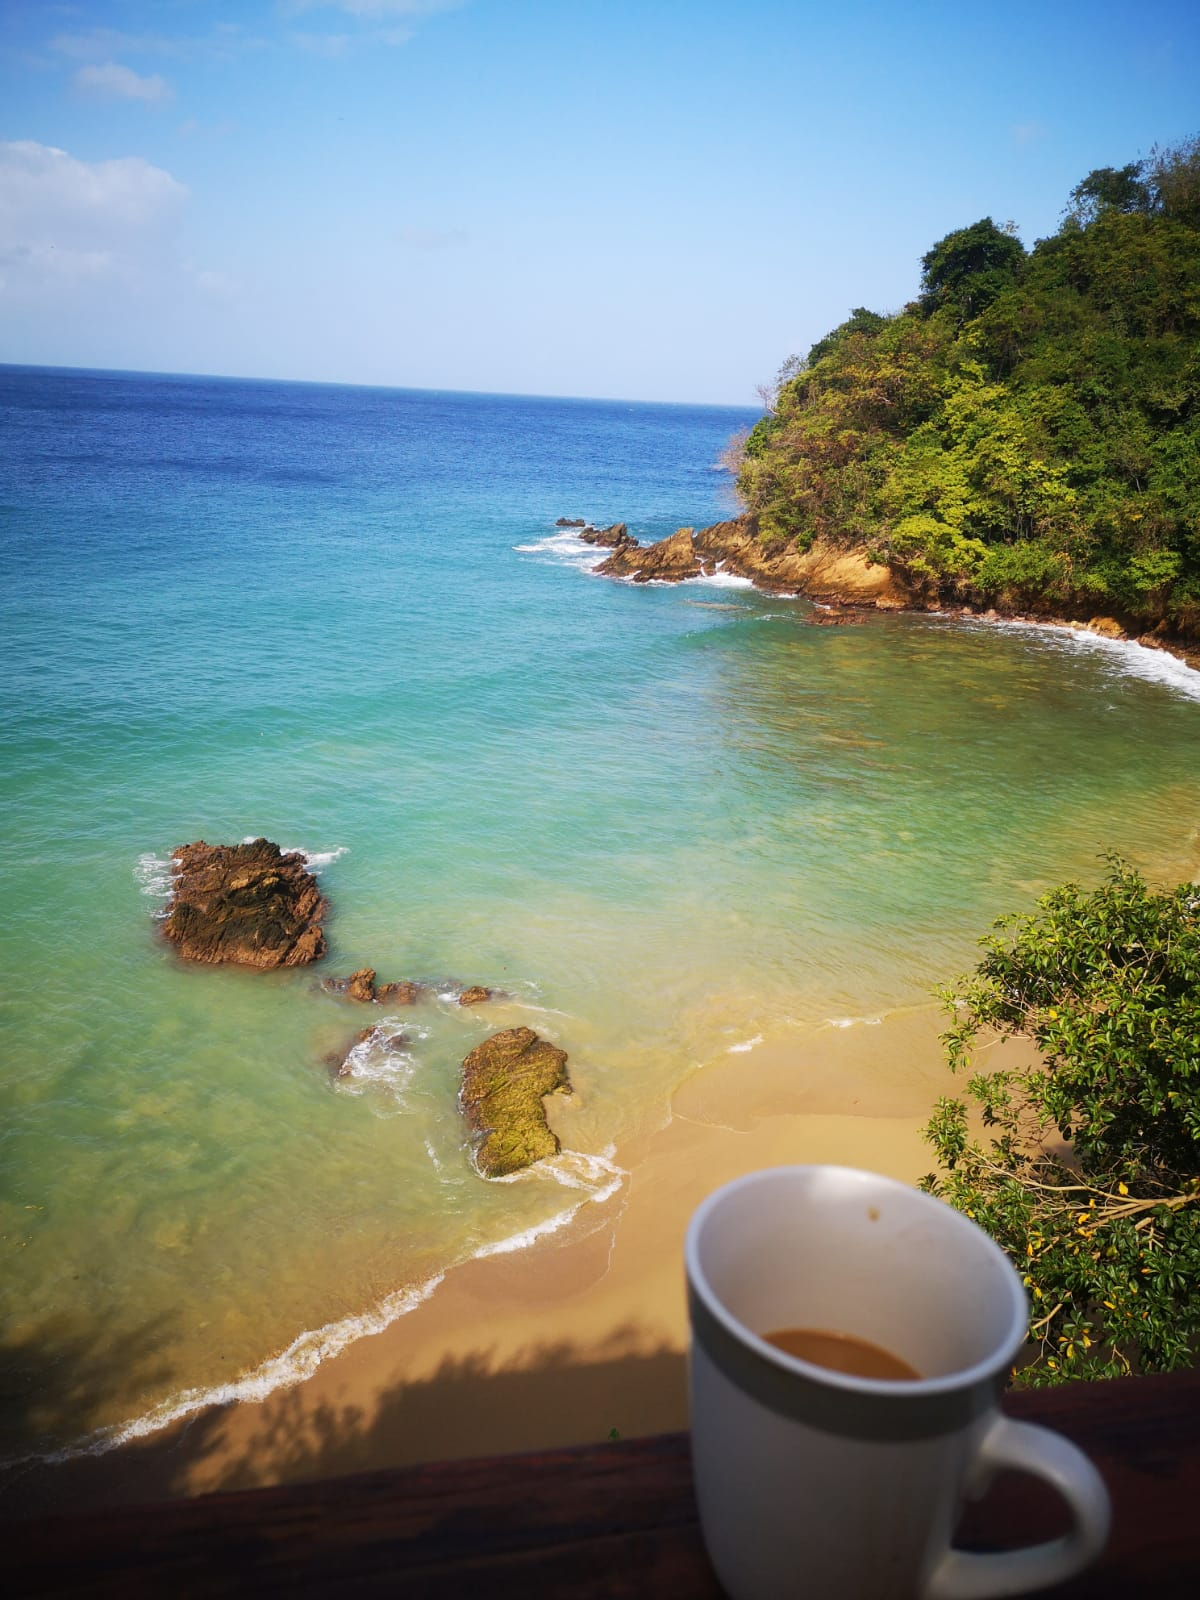

In [4]:
# Make gradients calculations from the output channels of the target layer.
# Selection of which output channels of the layer can be done
def get_gradients(net_in, net, layer, out_channels = None):     
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  if out_channels == None:
    loss = hook.output[0].norm()
  else:
    loss = hook.output[0][out_channels].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

# Function to run the dream. The excesive casts to and from numpy arrays is to make use of the np.roll() function.
# By rolling the image randomly everytime the gradients are computed, we prevent a tile effect artifact from appearing.
def dream(image, net, layer, iterations, lr, out_channels = None):
  image_numpy = np.array(image)
  image_tensor = transforms.ToTensor()(image_numpy)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                               ])
  for i in range(iterations):
    roll_x = np.random.randint(image_numpy.shape[0])
    roll_y = np.random.randint(image_numpy.shape[1])
    img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
    img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float)
    gradients_np = get_gradients(img_roll_tensor, net, layer, out_channels).detach().cpu().numpy()
    gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
    gradients_tensor = torch.tensor(gradients_np).cuda()
    image_tensor.data = image_tensor.data + lr * gradients_tensor.data

  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy()
  img_out_np = img_out_np.transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

# Input image
url = 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
#img = img.resize(new_size.astype(int))
layer = list( vgg.features.modules() )[27]

from IPython.display import Image as Img

display(img)

C:\Users\enosj\AppData\Local\Temp\ipykernel_3124\1785541801.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(new_size.astype(int), Image.ANTIALIAS)


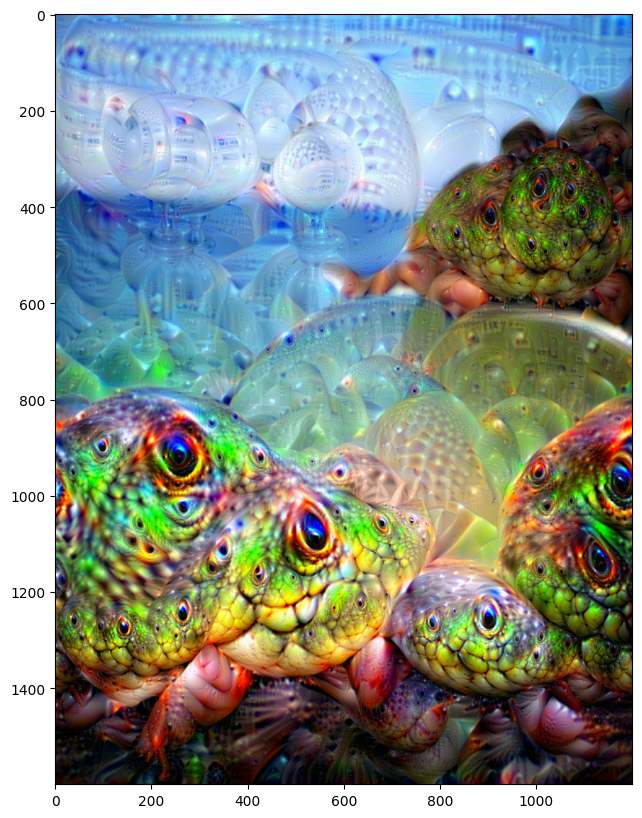

In [5]:
# Visualize features at different scales, the image is resized multiple times and run thru the dream
OCTAVE_SCALE = 1.5
for n in range(-7,1):
  new_size = orig_size * (OCTAVE_SCALE**n)
  img = img.resize(new_size.astype(int), Image.ANTIALIAS)
  img = dream(img, vgg, layer, 50, 0.05, out_channels = None)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)